# Esercitazione 10 
_Apprendimento da pochi esempi_

# Richieste:

1. Cambiare il classificatore finale SVM e trovare gli iperparametri migliori. 
2. Cosa succede se si stabilisce una soglia migliore per 2 o piu' classificatori diversi.
3. Confrontate altri classificatori: `knn`, `regressione logistica`, `random forest`, `MLP`.
4. Utilizzate Naive Bayes con calibrazione. 
5. Fate un esempio con Active Learning. 

## Confronto su diversi classificatori

Performing randomized search for hyperparameter optimization...
Optimizing KNN...
  Best params: {'weights': 'uniform', 'n_neighbors': 3}
  Best CV score: 0.9804
Optimizing SVC...
  Best params: {'gamma': 'scale', 'C': 10}
  Best CV score: 0.9804
Optimizing MLP...


/home/anisa_bakiu/anaconda3/envs/pydata-book/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


  Best params: {'hidden_layer_sizes': (50, 50), 'alpha': 0.1}
  Best CV score: 0.9412
Optimizing LogisticRegression...
  Best params: {'solver': 'lbfgs', 'C': 0.1}
  Best CV score: 0.9804

Running self-training with optimized classifiers...
Running self-training for optimized KNN...
Running self-training for optimized SVC...
Running self-training for optimized MLP...
Running self-training for optimized LogisticRegression...

ACCURACY SUMMARY FOR OPTIMIZED MODELS

KNN:
  Mean Accuracy: 0.9138
  Std Accuracy:  0.0385
  Max Accuracy:  0.9632
  Min Accuracy:  0.8571
  Total Runs:    42

SVC:
  Mean Accuracy: 0.8980
  Std Accuracy:  0.0378
  Max Accuracy:  0.9421
  Min Accuracy:  0.8413
  Total Runs:    42

MLP:
  Mean Accuracy: 0.7961
  Std Accuracy:  0.1511
  Max Accuracy:  0.9368
  Min Accuracy:  0.3579
  Total Runs:    42

LogisticRegression:
  Mean Accuracy: 0.9242
  Std Accuracy:  0.0267
  Max Accuracy:  0.9632
  Min Accuracy:  0.8889
  Total Runs:    42

Best performing optimized mod

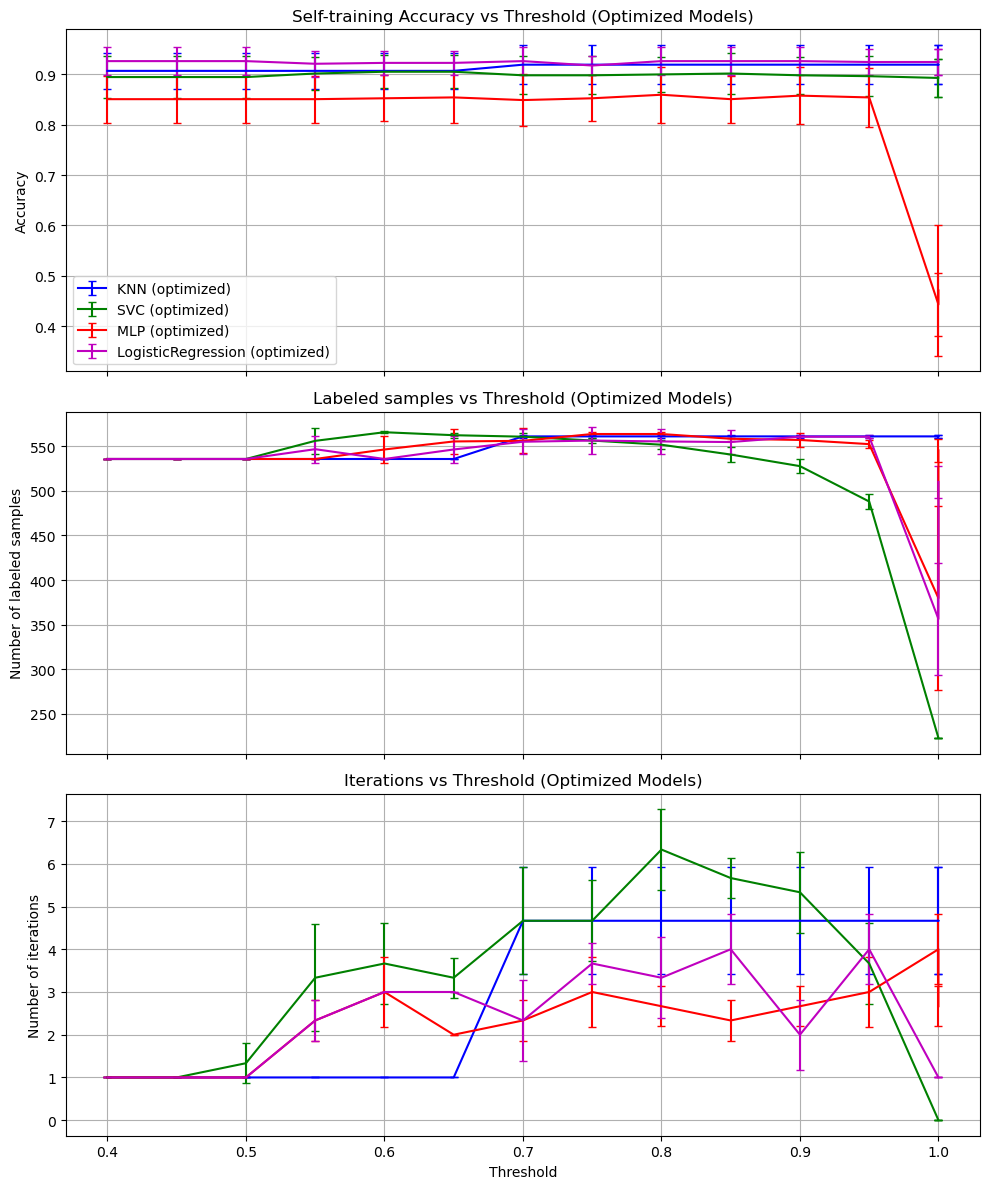

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

n_splits = 3
X, y = load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1  # unlabeled
total_samples = y.shape[0]

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)

# Simple parameter grids for fast randomized search
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.01, 0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'alpha': [0.001, 0.01, 0.1]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }
}

# Base classifiers
base_classifiers = {
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'MLP': MLPClassifier(max_iter=300, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=300)
}

print("Performing randomized search for hyperparameter optimization...")
print("="*60)

# Optimize hyperparameters using labeled data only
X_labeled = X[:50]  # Only first 50 samples are labeled
y_labeled = y[:50]

optimized_classifiers = {}
for name, base_clf in base_classifiers.items():
    print(f"Optimizing {name}...")
    
    # Fast randomized search with fewer iterations
    random_search = RandomizedSearchCV(
        base_clf, 
        param_grids[name],
        n_iter=8,
        cv=3,      
        scoring='accuracy',
        random_state=42,
        n_jobs=-1  # Use all cores for speed
    )
    
    random_search.fit(X_labeled, y_labeled)
    optimized_classifiers[name] = random_search.best_estimator_
    
    print(f"  Best params: {random_search.best_params_}")
    print(f"  Best CV score: {random_search.best_score_:.4f}")

print("\nRunning self-training with optimized classifiers...")
print("="*60)

# Containers for results
results = {}
accuracy_summary = {}

for name in optimized_classifiers:
    results[name] = {
        'scores': np.empty((len(x_values), n_splits)),
        'amount_labeled': np.empty((len(x_values), n_splits)),
        'amount_iterations': np.empty((len(x_values), n_splits))
    }
    accuracy_summary[name] = {
        'all_scores': [],
        'mean_accuracy': 0,
        'std_accuracy': 0,
        'max_accuracy': 0,
        'min_accuracy': 0
    }

for name, base_clf in optimized_classifiers.items():
    print(f"Running self-training for optimized {name}...")
    
    for i, threshold in enumerate(x_values):
        self_training_clf = SelfTrainingClassifier(base_clf, threshold=threshold, max_iter=50) 
        skfolds = StratifiedKFold(n_splits=n_splits)
        
        for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
            y_test_true = y_true[test_index]
            
            self_training_clf.fit(X_train, y_train)
            
            # number of labeled examples at end of training
            labeled_counts = np.unique(self_training_clf.labeled_iter_, return_counts=True)[1]
            # The first count corresponds to initially labeled samples, subtract from total
            amount_labeled = total_samples - labeled_counts[0]
            results[name]['amount_labeled'][i, fold] = amount_labeled
            results[name]['amount_iterations'][i, fold] = np.max(self_training_clf.labeled_iter_)
            
            y_pred = self_training_clf.predict(X_test)
            accuracy = accuracy_score(y_test_true, y_pred)
            results[name]['scores'][i, fold] = accuracy
            
            # Store accuracy for summary statistics
            accuracy_summary[name]['all_scores'].append(accuracy)

# Calculate summary statistics for each model
for name in optimized_classifiers:
    all_scores = np.array(accuracy_summary[name]['all_scores'])
    accuracy_summary[name]['mean_accuracy'] = np.mean(all_scores)
    accuracy_summary[name]['std_accuracy'] = np.std(all_scores)
    accuracy_summary[name]['max_accuracy'] = np.max(all_scores)
    accuracy_summary[name]['min_accuracy'] = np.min(all_scores)

# Print accuracy summary for each model
print("\n" + "="*60)
print("ACCURACY SUMMARY FOR OPTIMIZED MODELS")
print("="*60)

for name in optimized_classifiers:
    print(f"\n{name}:")
    print(f"  Mean Accuracy: {accuracy_summary[name]['mean_accuracy']:.4f}")
    print(f"  Std Accuracy:  {accuracy_summary[name]['std_accuracy']:.4f}")
    print(f"  Max Accuracy:  {accuracy_summary[name]['max_accuracy']:.4f}")
    print(f"  Min Accuracy:  {accuracy_summary[name]['min_accuracy']:.4f}")
    print(f"  Total Runs:    {len(accuracy_summary[name]['all_scores'])}")

# Find best performing model
best_model = max(accuracy_summary.keys(), key=lambda x: accuracy_summary[x]['mean_accuracy'])
print(f"\nBest performing optimized model: {best_model} (Mean Accuracy: {accuracy_summary[best_model]['mean_accuracy']:.4f})")

# Plotting all classifiers on same plots
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
colors = ['b', 'g', 'r', 'm']

# Accuracy plot
for i, (name, res) in enumerate(results.items()):
    mean_scores = res['scores'].mean(axis=1)
    std_scores = res['scores'].std(axis=1)
    axs[0].errorbar(x_values, mean_scores, yerr=std_scores, label=f'{name} (optimized)', color=colors[i], capsize=3)

axs[0].set_ylabel('Accuracy')
axs[0].set_title('Self-training Accuracy vs Threshold (Optimized Models)')
axs[0].legend()
axs[0].grid(True)

# Number labeled plot
for i, (name, res) in enumerate(results.items()):
    mean_labeled = res['amount_labeled'].mean(axis=1)
    std_labeled = res['amount_labeled'].std(axis=1)
    axs[1].errorbar(x_values, mean_labeled, yerr=std_labeled, label=f'{name} (optimized)', color=colors[i], capsize=3)

axs[1].set_ylabel('Number of labeled samples')
axs[1].set_title('Labeled samples vs Threshold (Optimized Models)')
axs[1].grid(True)

# Number iterations plot
for i, (name, res) in enumerate(results.items()):
    mean_iters = res['amount_iterations'].mean(axis=1)
    std_iters = res['amount_iterations'].std(axis=1)
    axs[2].errorbar(x_values, mean_iters, yerr=std_iters, label=f'{name} (optimized)', color=colors[i], capsize=3)

axs[2].set_ylabel('Number of iterations')
axs[2].set_xlabel('Threshold')
axs[2].set_title('Iterations vs Threshold (Optimized Models)')
axs[2].grid(True)

plt.tight_layout()
plt.show()

## Naive Bayes con calibrazione

Performing randomized search for Naive Bayes with calibration...
Optimizing Calibrated Naive Bayes...
Best params: {'method': 'isotonic', 'estimator__var_smoothing': 1e-06, 'cv': 5}
Best CV score: 0.9804

Creating non-calibrated Naive Bayes for comparison...

Running self-training with both calibrated and non-calibrated Naive Bayes...
Running self-training for NaiveBayes_Calibrated...
Running self-training for NaiveBayes_NonCalibrated...

ACCURACY SUMMARY FOR NAIVE BAYES MODELS

NaiveBayes_Calibrated:
  Mean Accuracy: 0.9145
  Std Accuracy:  0.0197
  Max Accuracy:  0.9368
  Min Accuracy:  0.8783
  Total Runs:    42

NaiveBayes_NonCalibrated:
  Mean Accuracy: 0.9096
  Std Accuracy:  0.0255
  Max Accuracy:  0.9421
  Min Accuracy:  0.8677
  Total Runs:    42

CALIBRATION IMPACT:
Calibrated NB Mean Accuracy:     0.9145
Non-Calibrated NB Mean Accuracy: 0.9096
Improvement from calibration:    0.0049 (0.49%)
✓ Calibration IMPROVED performance!


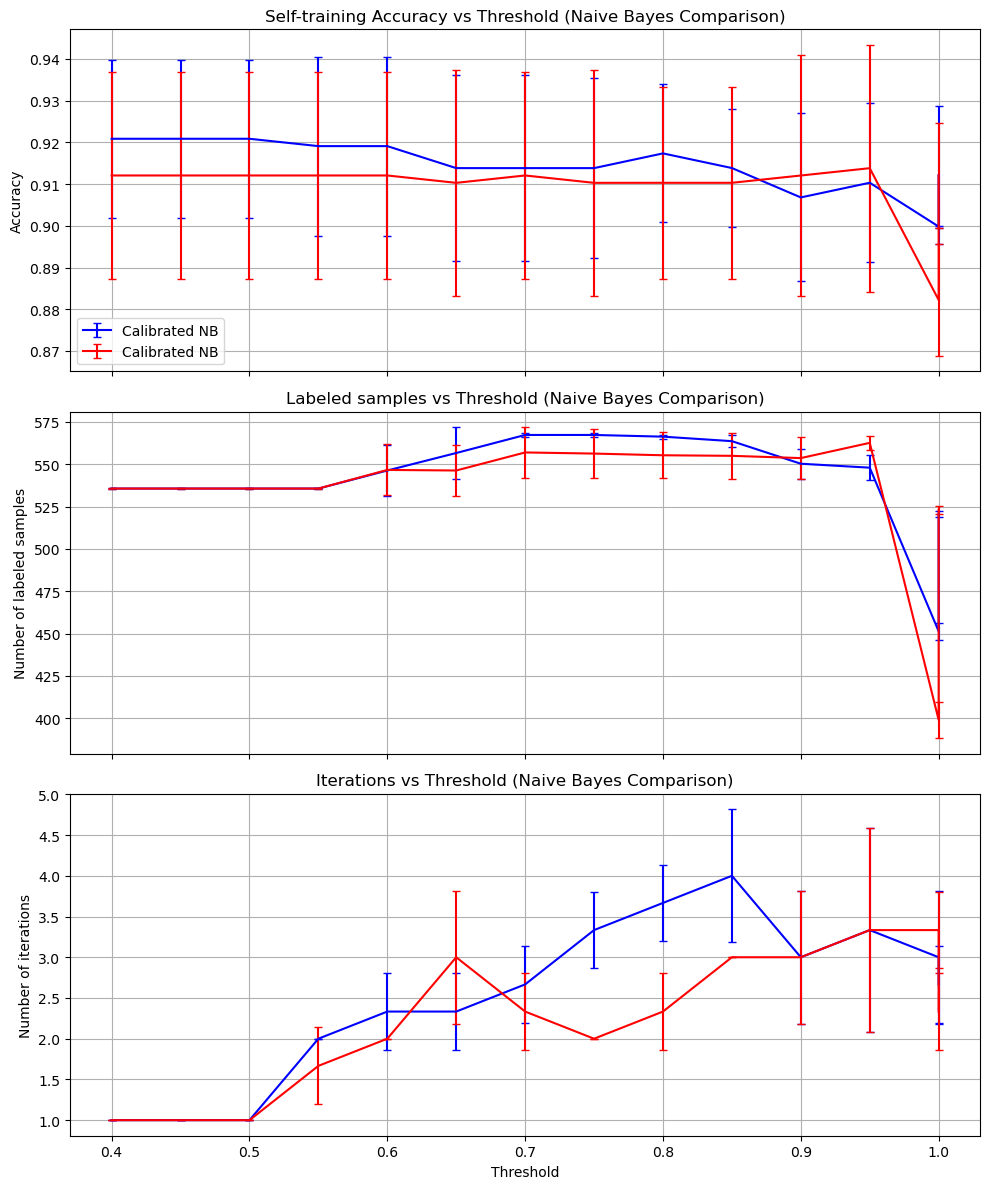


Calibration method used: isotonic
Cross-validation folds for calibration: 5
Variance smoothing parameter: 1e-06


In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

n_splits = 3
X, y = load_breast_cancer(return_X_y=True)
X, y = shuffle(X, y, random_state=42)
y_true = y.copy()
y[50:] = -1  # unlabeled
total_samples = y.shape[0]

x_values = np.arange(0.4, 1.05, 0.05)
x_values = np.append(x_values, 0.99999)

# Parameter grid for Naive Bayes with calibration
param_grid = {
    'estimator__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5],
    'method': ['sigmoid', 'isotonic'],
    'cv': [3, 5]
}

print("Performing randomized search for Naive Bayes with calibration...")
print("="*60)

# Optimize hyperparameters using labeled data only
X_labeled = X[:50]  # Only first 50 samples are labeled
y_labeled = y[:50]

# Create calibrated Naive Bayes classifier
base_nb = GaussianNB()
calibrated_nb = CalibratedClassifierCV(base_nb, method='sigmoid', cv=3)

print("Optimizing Calibrated Naive Bayes...")

# Fast randomized search
random_search = RandomizedSearchCV(
    calibrated_nb, 
    param_grid,
    n_iter=10,  
    cv=3,       
    scoring='accuracy',
    random_state=42,
    n_jobs=-1   
)

random_search.fit(X_labeled, y_labeled)
optimized_nb = random_search.best_estimator_

print(f"Best params: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.4f}")

# Also create a non-calibrated version for comparison
print("\nCreating non-calibrated Naive Bayes for comparison...")
base_nb_comparison = GaussianNB(var_smoothing=random_search.best_params_['estimator__var_smoothing'])

print("\nRunning self-training with both calibrated and non-calibrated Naive Bayes...")
print("="*60)

# Classifiers to compare
classifiers = {
    'NaiveBayes_Calibrated': optimized_nb,
    'NaiveBayes_NonCalibrated': base_nb_comparison
}

# Containers for results
results = {}
accuracy_summary = {}

for name in classifiers:
    results[name] = {
        'scores': np.empty((len(x_values), n_splits)),
        'amount_labeled': np.empty((len(x_values), n_splits)),
        'amount_iterations': np.empty((len(x_values), n_splits))
    }
    accuracy_summary[name] = {
        'all_scores': [],
        'mean_accuracy': 0,
        'std_accuracy': 0,
        'max_accuracy': 0,
        'min_accuracy': 0
    }

for name, base_clf in classifiers.items():
    print(f"Running self-training for {name}...")
    
    for i, threshold in enumerate(x_values):
        self_training_clf = SelfTrainingClassifier(base_clf, threshold=threshold, max_iter=50)
        skfolds = StratifiedKFold(n_splits=n_splits)
        
        for fold, (train_index, test_index) in enumerate(skfolds.split(X, y)):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]
            y_test_true = y_true[test_index]
            
            self_training_clf.fit(X_train, y_train)
            
            # number of labeled examples at end of training
            labeled_counts = np.unique(self_training_clf.labeled_iter_, return_counts=True)[1]
            # The first count corresponds to initially labeled samples, subtract from total
            amount_labeled = total_samples - labeled_counts[0]
            results[name]['amount_labeled'][i, fold] = amount_labeled
            results[name]['amount_iterations'][i, fold] = np.max(self_training_clf.labeled_iter_)
            
            y_pred = self_training_clf.predict(X_test)
            accuracy = accuracy_score(y_test_true, y_pred)
            results[name]['scores'][i, fold] = accuracy
            
            # Store accuracy for summary statistics
            accuracy_summary[name]['all_scores'].append(accuracy)

# Calculate summary statistics for each model
for name in classifiers:
    all_scores = np.array(accuracy_summary[name]['all_scores'])
    accuracy_summary[name]['mean_accuracy'] = np.mean(all_scores)
    accuracy_summary[name]['std_accuracy'] = np.std(all_scores)
    accuracy_summary[name]['max_accuracy'] = np.max(all_scores)
    accuracy_summary[name]['min_accuracy'] = np.min(all_scores)

# Print accuracy summary for each model
print("\n" + "="*60)
print("ACCURACY SUMMARY FOR NAIVE BAYES MODELS")
print("="*60)

for name in classifiers:
    print(f"\n{name}:")
    print(f"  Mean Accuracy: {accuracy_summary[name]['mean_accuracy']:.4f}")
    print(f"  Std Accuracy:  {accuracy_summary[name]['std_accuracy']:.4f}")
    print(f"  Max Accuracy:  {accuracy_summary[name]['max_accuracy']:.4f}")
    print(f"  Min Accuracy:  {accuracy_summary[name]['min_accuracy']:.4f}")
    print(f"  Total Runs:    {len(accuracy_summary[name]['all_scores'])}")

# Compare calibrated vs non-calibrated
calibrated_acc = accuracy_summary['NaiveBayes_Calibrated']['mean_accuracy']
non_calibrated_acc = accuracy_summary['NaiveBayes_NonCalibrated']['mean_accuracy']
improvement = calibrated_acc - non_calibrated_acc

print(f"\nCALIBRATION IMPACT:")
print(f"Calibrated NB Mean Accuracy:     {calibrated_acc:.4f}")
print(f"Non-Calibrated NB Mean Accuracy: {non_calibrated_acc:.4f}")
print(f"Improvement from calibration:    {improvement:.4f} ({improvement*100:.2f}%)")

if improvement > 0:
    print("✓ Calibration IMPROVED performance!")
else:
    print("✗ Calibration did not improve performance")

# Plotting all classifiers on same plots
fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
colors = ['b', 'r']

# Accuracy plot
for i, (name, res) in enumerate(results.items()):
    mean_scores = res['scores'].mean(axis=1)
    std_scores = res['scores'].std(axis=1)
    label = 'Calibrated NB' if 'Calibrated' in name else 'Non-Calibrated NB'
    axs[0].errorbar(x_values, mean_scores, yerr=std_scores, label=label, color=colors[i], capsize=3)

axs[0].set_ylabel('Accuracy')
axs[0].set_title('Self-training Accuracy vs Threshold (Naive Bayes Comparison)')
axs[0].legend()
axs[0].grid(True)

# Number labeled plot
for i, (name, res) in enumerate(results.items()):
    mean_labeled = res['amount_labeled'].mean(axis=1)
    std_labeled = res['amount_labeled'].std(axis=1)
    label = 'Calibrated NB' if 'Calibrated' in name else 'Non-Calibrated NB'
    axs[1].errorbar(x_values, mean_labeled, yerr=std_labeled, label=label, color=colors[i], capsize=3)

axs[1].set_ylabel('Number of labeled samples')
axs[1].set_title('Labeled samples vs Threshold (Naive Bayes Comparison)')
axs[1].grid(True)

# Number iterations plot
for i, (name, res) in enumerate(results.items()):
    mean_iters = res['amount_iterations'].mean(axis=1)
    std_iters = res['amount_iterations'].std(axis=1)
    label = 'Calibrated NB' if 'Calibrated' in name else 'Non-Calibrated NB'
    axs[2].errorbar(x_values, mean_iters, yerr=std_iters, label=label, color=colors[i], capsize=3)

axs[2].set_ylabel('Number of iterations')
axs[2].set_xlabel('Threshold')
axs[2].set_title('Iterations vs Threshold (Naive Bayes Comparison)')
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Print calibration method used
print(f"\nCalibration method used: {random_search.best_params_['method']}")
print(f"Cross-validation folds for calibration: {random_search.best_params_['cv']}")
print(f"Variance smoothing parameter: {random_search.best_params_['estimator__var_smoothing']}")

## Active learning

Cambiare dataset

### Pool based active learning

POOL-BASED ACTIVE LEARNING TUTORIAL
Pool-based AL: We have a large pool of unlabeled data
and strategically select which samples to label.

STEP 1: Creating synthetic dataset...
✓ Generated 200 samples with 4 classes
✓ Feature space: 2D
✓ Class distribution: [50 50 50 50]

STEP 2: Setting up the POOL of unlabeled data...
✓ POOL SIZE: 0 unlabeled samples
✓ INITIAL LABELED: 200 samples
✓ POOL-BASED AL: We'll query from the pool strategically

STEP 3: Setting up active learning components...
✓ Classifier: Gaussian Process (probabilistic)
✓ Query strategy: Uncertainty Sampling (entropy-based)
✓ Strategy: Query most uncertain samples FROM THE POOL

STEP 4: Running active learning cycles...
Running 20 pool-based active learning cycles...
Cycle | Pool Size | Labeled | Accuracy | Improvement
--------------------------------------------------
    1 |         0 |     200 | 1.0000  | baseline
      → Queried sample [78] from pool, true label: [2]
    2 |         0 |     200 | 1.0000  | +0.0000
  

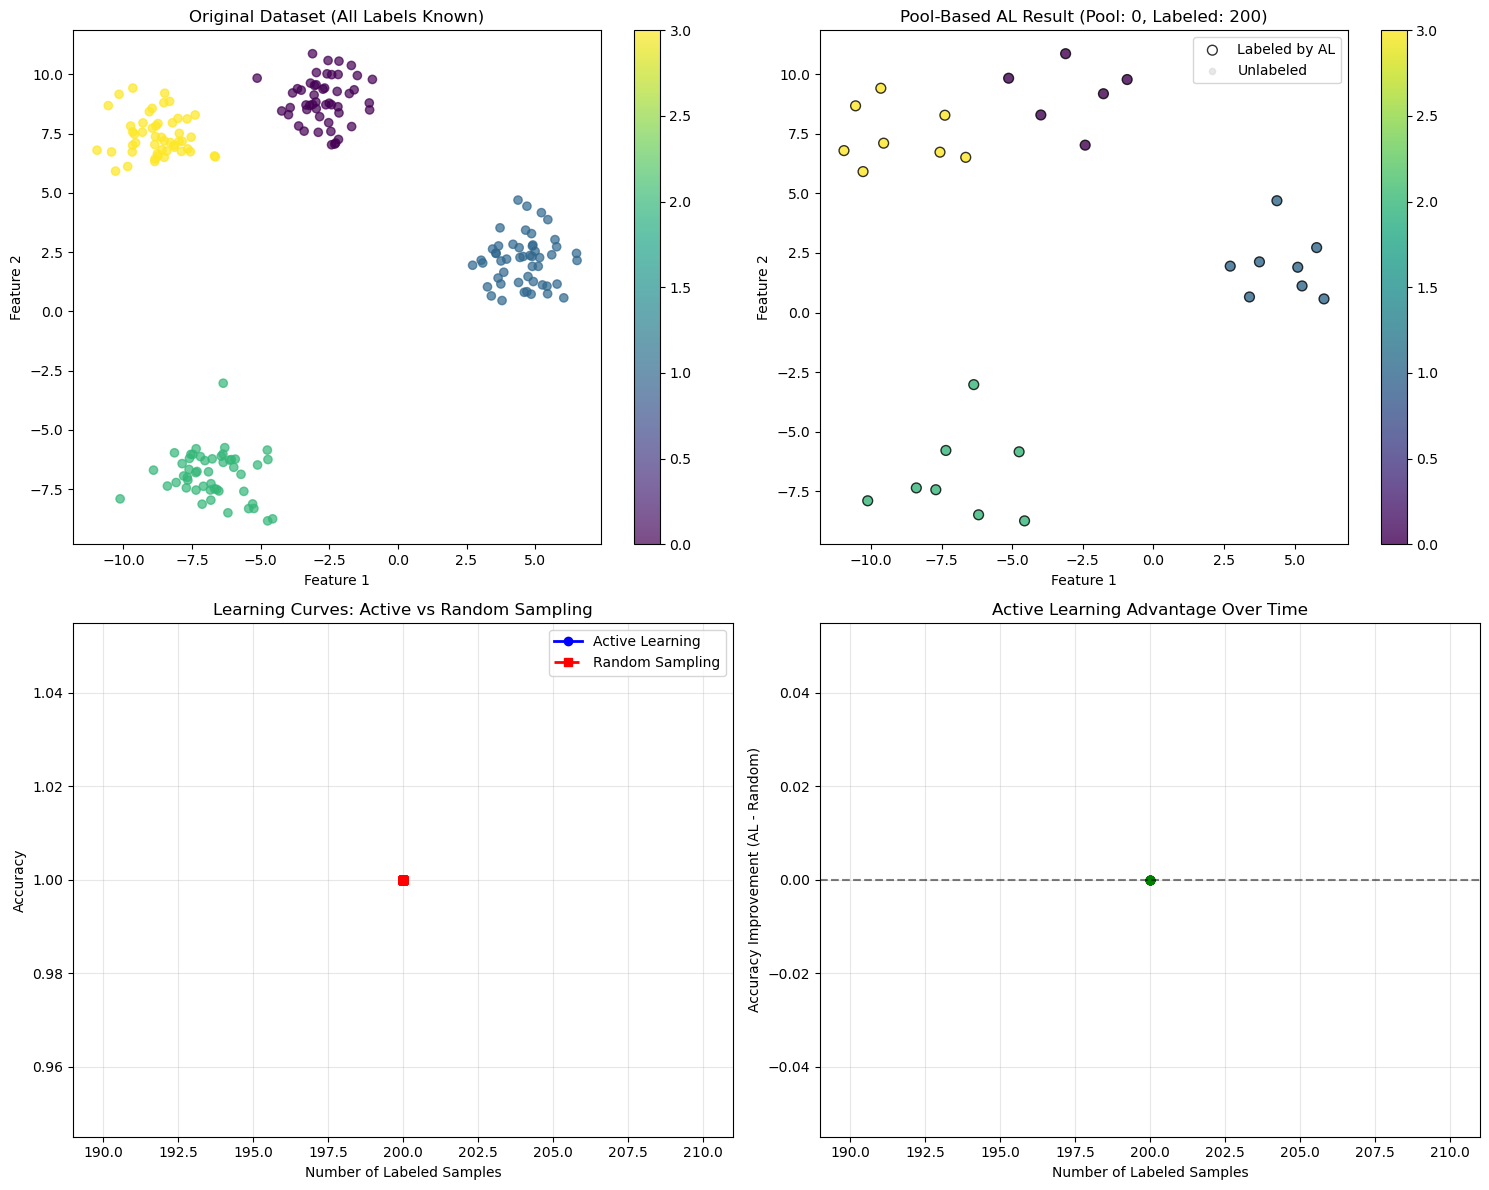


HOW POOL-BASED ACTIVE LEARNING WORKS:
1. START: Small labeled set + Large POOL of unlabeled data
2. TRAIN: Fit model on current labeled data
3. QUERY: Scan the POOL, find most uncertain unlabeled sample
4. LABEL: Get true label for that sample (ask human expert)
5. UPDATE: Move sample from pool to labeled set
6. REPEAT: Continue until pool is empty or budget exhausted

POOL-BASED ADVANTAGES:
• Realistic scenario: You have collected data but labeling is expensive
• Efficient: Focus labeling effort on most informative samples
• Flexible: Can stop anytime based on budget or performance
• Scalable: Works with large pools of unlabeled data

KEY COMPONENTS:
• POOL: Collection of unlabeled samples to choose from
• Query Strategy: How to select next sample from pool
• Base Classifier: Must provide uncertainty estimates
• Oracle: Source of true labels (human expert, existing labels, etc.)

COMMON QUERY STRATEGIES:
• Uncertainty Sampling: Select most uncertain samples
• Diversity Sampling: Sele

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import MISSING_LABEL
from skactiveml.classifier import SklearnClassifier

# Set random seed for reproducibility
np.random.seed(42)

print("="*60)
print("POOL-BASED ACTIVE LEARNING TUTORIAL")
print("="*60)
print("Pool-based AL: We have a large pool of unlabeled data")
print("and strategically select which samples to label.\n")

# ============================================================================
# STEP 1: Generate synthetic dataset
# ============================================================================
print("STEP 1: Creating synthetic dataset...")
n_samples = 200
n_centers = 4
X, y_true = make_blobs(n_samples=n_samples, centers=n_centers, random_state=42)

print(f"✓ Generated {n_samples} samples with {n_centers} classes")
print(f"✓ Feature space: {X.shape[1]}D")
print(f"✓ Class distribution: {np.bincount(y_true)}")

# ============================================================================
# STEP 2: Create the "pool" of unlabeled data
# ============================================================================
print("\nSTEP 2: Setting up the POOL of unlabeled data...")

# POOL-BASED SETUP: Start with ALL samples unlabeled (this is our "pool")
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

# Label only a small initial set as "seed" training data
n_initial = 10
initial_indices = np.random.choice(len(X), n_initial, replace=False)
y[initial_indices] = y_true[initial_indices]

# Our "pool" consists of all the unlabeled samples
pool_indices = np.where(y == MISSING_LABEL)[0]
labeled_indices = np.where(y != MISSING_LABEL)[0]

print(f"✓ POOL SIZE: {len(pool_indices)} unlabeled samples")
print(f"✓ INITIAL LABELED: {len(labeled_indices)} samples")
print(f"✓ POOL-BASED AL: We'll query from the pool strategically")

# ============================================================================
# STEP 3: Set up classifier and active learning strategy
# ============================================================================
print("\nSTEP 3: Setting up active learning components...")

# Classifier: Gaussian Process (good for uncertainty estimation)
clf = SklearnClassifier(
    GaussianProcessClassifier(random_state=42),
    classes=np.unique(y_true),  # Tell classifier about all possible classes
    random_state=42
)

# Query Strategy: Uncertainty Sampling with entropy (queries from the pool)
# Entropy method: selects samples from pool where the model is most uncertain
qs = UncertaintySampling(method='entropy')

print("✓ Classifier: Gaussian Process (probabilistic)")
print("✓ Query strategy: Uncertainty Sampling (entropy-based)")
print("✓ Strategy: Query most uncertain samples FROM THE POOL")

# ============================================================================
# STEP 4: Execute active learning cycles
# ============================================================================
print("\nSTEP 4: Running active learning cycles...")

n_cycles = 20
accuracies = []
labeled_counts = []

print(f"Running {n_cycles} pool-based active learning cycles...")
print("Cycle | Pool Size | Labeled | Accuracy | Improvement")
print("-" * 50)

for cycle in range(n_cycles):
    # Fit classifier on currently labeled data
    clf.fit(X, y)
    
    # Evaluate on all true labels
    y_pred_all = clf.predict(X)
    accuracy = accuracy_score(y_true, y_pred_all)
    accuracies.append(accuracy)
    
    # Count current pool size and labeled samples
    current_pool_size = np.sum(y == MISSING_LABEL)
    n_currently_labeled = np.sum(y != MISSING_LABEL)
    labeled_counts.append(n_currently_labeled)
    
    # Print progress
    if cycle == 0:
        print(f"{cycle+1:5d} | {current_pool_size:9d} | {n_currently_labeled:7d} | {accuracy:.4f}  | baseline")
    else:
        improvement = accuracy - accuracies[cycle-1]
        print(f"{cycle+1:5d} | {current_pool_size:9d} | {n_currently_labeled:7d} | {accuracy:.4f}  | {improvement:+.4f}")
    
    # POOL-BASED QUERY: find the most uncertain sample from the remaining pool
    # The query strategy will only consider unlabeled samples (the pool)
    query_idx = qs.query(X=X, y=y, clf=clf)
    
    # "Label" the selected sample (reveal its true label)
    # This removes it from the pool and adds it to labeled set
    y[query_idx] = y_true[query_idx]
    
    print(f"      → Queried sample {query_idx} from pool, true label: {y_true[query_idx]}")

# ============================================================================
# STEP 5: Final evaluation and comparison
# ============================================================================
print("\nSTEP 5: Final evaluation...")

# Fit final classifier
clf.fit(X, y)
final_accuracy = accuracy_score(y_true, clf.predict(X))

# Compare with random sampling baseline
print("\nComparing with random sampling baseline...")
np.random.seed(42)
y_random = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)
y_random[:n_initial] = y_true[:n_initial]

# Random sampling
random_accuracies = []
for cycle in range(n_cycles):
    clf_random = SklearnClassifier(
        GaussianProcessClassifier(random_state=42),
        classes=np.unique(y_true),
        random_state=42
    )
    clf_random.fit(X, y_random)
    acc_random = accuracy_score(y_true, clf_random.predict(X))
    random_accuracies.append(acc_random)
    
    # Randomly select next sample to label
    unlabeled_indices = np.where(y_random == MISSING_LABEL)[0]
    if len(unlabeled_indices) > 0:
        random_idx = np.random.choice(unlabeled_indices)
        y_random[random_idx] = y_true[random_idx]

print(f"\nFINAL RESULTS:")
print(f"Active Learning accuracy:  {accuracies[-1]:.4f}")
print(f"Random Sampling accuracy:  {random_accuracies[-1]:.4f}")
print(f"Improvement from AL:       {accuracies[-1] - random_accuracies[-1]:+.4f}")
print(f"Total samples labeled:     {np.sum(y != MISSING_LABEL)}/{len(y)}")

# ============================================================================
# STEP 6: Visualization
# ============================================================================
print("\nSTEP 6: Creating visualizations...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Original data
scatter1 = ax1.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', alpha=0.7)
ax1.set_title('Original Dataset (All Labels Known)')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
plt.colorbar(scatter1, ax=ax1)

# Plot 2: Final active learning result
labeled_mask = y != MISSING_LABEL
scatter2 = ax2.scatter(X[labeled_mask, 0], X[labeled_mask, 1], 
                      c=y[labeled_mask], cmap='viridis', s=50, alpha=0.8, 
                      edgecolors='black', linewidth=1, label='Labeled by AL')
ax2.scatter(X[~labeled_mask, 0], X[~labeled_mask, 1], 
           c='lightgray', s=20, alpha=0.5, label='Unlabeled')
ax2.set_title(f'Pool-Based AL Result (Pool: {np.sum(~labeled_mask)}, Labeled: {np.sum(labeled_mask)})')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.legend()
plt.colorbar(scatter2, ax=ax2)

# Plot 3: Learning curves comparison
ax3.plot(labeled_counts, accuracies, 'b-o', label='Active Learning', linewidth=2)
ax3.plot(labeled_counts, random_accuracies, 'r--s', label='Random Sampling', linewidth=2)
ax3.set_xlabel('Number of Labeled Samples')
ax3.set_ylabel('Accuracy')
ax3.set_title('Learning Curves: Active vs Random Sampling')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Improvement over time
improvements = np.array(accuracies) - np.array(random_accuracies)
ax4.plot(labeled_counts, improvements, 'g-o', linewidth=2)
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Number of Labeled Samples')
ax4.set_ylabel('Accuracy Improvement (AL - Random)')
ax4.set_title('Active Learning Advantage Over Time')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# EXPLANATION SUMMARY
# ============================================================================
print("\n" + "="*60)
print("HOW POOL-BASED ACTIVE LEARNING WORKS:")
print("="*60)
print("1. START: Small labeled set + Large POOL of unlabeled data")
print("2. TRAIN: Fit model on current labeled data")
print("3. QUERY: Scan the POOL, find most uncertain unlabeled sample")
print("4. LABEL: Get true label for that sample (ask human expert)")
print("5. UPDATE: Move sample from pool to labeled set")
print("6. REPEAT: Continue until pool is empty or budget exhausted")
print("\nPOOL-BASED ADVANTAGES:")
print("• Realistic scenario: You have collected data but labeling is expensive")
print("• Efficient: Focus labeling effort on most informative samples")
print("• Flexible: Can stop anytime based on budget or performance")
print("• Scalable: Works with large pools of unlabeled data")
print("\nKEY COMPONENTS:")
print("• POOL: Collection of unlabeled samples to choose from")
print("• Query Strategy: How to select next sample from pool")
print("• Base Classifier: Must provide uncertainty estimates")
print("• Oracle: Source of true labels (human expert, existing labels, etc.)")
print("\nCOMMON QUERY STRATEGIES:")
print("• Uncertainty Sampling: Select most uncertain samples")
print("• Diversity Sampling: Select diverse/representative samples")
print("• Hybrid: Combine uncertainty + diversity")

### Stream Based active learning

In [35]:
import numpy as np
from sklearn.datasets import make_blobs
from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.stream import Split
from skactiveml.utils import MISSING_LABEL

# Generate data set
X, y_true = make_blobs(n_samples=200, centers=4, random_state=0)

# Create classifier and query strategy
clf = ParzenWindowClassifier(random_state=0, classes=np.unique(y_true))
qs = Split(random_state=0)

# Initialize training data as empty arrays (not lists for sklearn compatibility)
X_train = np.empty((0, X.shape[1]))
y_train = np.array([])

# Initialize a list to store prediction results
correct_classifications = []

# Execute active learning cycle
for i, (x_t, y_t) in enumerate(zip(X, y_true)):
    # Reshape current sample for processing
    X_cand = x_t.reshape(1, -1)
    
    # Check if we have labeled training data
    has_labeled_data = len(y_train) > 0 and np.any(y_train != MISSING_LABEL)
    
    if has_labeled_data:
        # Filter out missing labels for training
        labeled_mask = y_train != MISSING_LABEL
        X_labeled = X_train[labeled_mask]
        y_labeled = y_train[labeled_mask]
        clf.fit(X_labeled, y_labeled)
        
        # Make prediction and check correctness
        pred = clf.predict(X_cand)[0]
        correct_classifications.append(pred == y_t)
        
        # Query strategy to decide whether to label this sample
        sampled_indices = qs.query(candidates=X_cand, clf=clf)
    else:
        # No labeled data yet, can't make prediction
        correct_classifications.append(False)
        
        # For the first few samples, label them to bootstrap the classifier
        if i < 2:  # Label first 2 samples to start training
            sampled_indices = np.array([0])
        else:
            sampled_indices = np.array([])  # Don't label until we have a trained classifier
    
    # Update query strategy
    qs.update(candidates=X_cand, queried_indices=sampled_indices)
    
    # Add sample to training set
    X_train = np.vstack([X_train, X_cand]) if len(X_train) > 0 else X_cand
    
    # Add label (true label if queried, MISSING_LABEL otherwise)
    if len(sampled_indices) > 0:
        y_train = np.append(y_train, y_t)
    else:
        y_train = np.append(y_train, MISSING_LABEL)

# Print results
print(f"Total samples processed: {len(X)}")
print(f"Samples labeled: {np.sum(y_train != MISSING_LABEL)}")
print(f"Labeling rate: {np.sum(y_train != MISSING_LABEL) / len(X):.2%}")
print(f"Classification accuracy: {np.mean(correct_classifications):.2%}")
print(f"Accuracy on samples with predictions: {np.mean([c for i, c in enumerate(correct_classifications) if y_train[i] != MISSING_LABEL]):.2%}")

Total samples processed: 200
Samples labeled: 200
Labeling rate: 100.00%
Classification accuracy: 87.00%
Accuracy on samples with predictions: 87.00%
